## Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [3]:
import os
import ast
import pandas as pd
from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import (
                StuffDocumentsChain,
                LLMChain,
                ReduceDocumentsChain,
                MapReduceDocumentsChain,
            )

## Data Cleaning

1. Import data from csv. 
2. Gather first questions from every conversation, assuming that the first question approximates the intent of the user in the entire conversation.
3. Remove Default questions to prevent them from being clustered.

In [2]:
# imports
import numpy as np
import pandas as pd
from langchain.embeddings import OpenAIEmbeddings

import os
os.environ["OPENAI_API_KEY"] = "<your-api-key>"

In [4]:

# load data
datafile_path = "data/langchain_data_may15_may30.csv"

#load into dataframe
df = pd.read_csv(datafile_path)

import ast

# Load the CSV data into a pandas DataFrame
df = pd.read_csv(datafile_path)

# Convert string representations of lists into actual lists
df['messages'] = df['messages'].apply(ast.literal_eval)


# Extract the first message from each conversation and create a new DataFrame
first_messages = [conv[0] if conv else None for conv in df['messages']]
df_first_questions = pd.DataFrame({
    'message': first_messages,
})

df_first_questions = df_first_questions[df_first_questions['message'] != "What is a prompt template?"]
df_first_questions = df_first_questions[df_first_questions['message'] != "How to cache llm calls?"]


# remove duplicate messages without destroying other columns
df_first_questions = df_first_questions.drop_duplicates(subset=['message'], keep='first')

df_first_questions.head()

,message
0,duckdb use persistence
1,does it change the documents at all
2,How to specify index dimentionality with opena...
4,why from langchain.memory is not working?
5,How to make my SequentialChain remember the ch...


Alright, now that we've preprocessed the data, we can start analzying it. Here is a high level diagram of the approach we will be taking to cluster the data.

![cluster.png](screenshots/cluster_visual.png)


The general workflow is as follows:

1. Vectorize the data using an embedding model (in this case, we use ada)
2. Cluster the data using k-means
3. Visualize the clusters using T-SNE
4. Sample questions from the cluster
5. Summarize sampled questions with GPT-4

## Embedding

Here, we take each message and use openAI's embedding model, ada-002, to embed the message as a vector. With this numerical representation of the messages meaning, we can use clustering algorithms to group similar messages together.

In [ ]:
def get_embedding(text):
    try:
        # print("used")

        embeddings = OpenAIEmbeddings()
        result = embeddings.embed_query(text)
    except: 
        print("text", text)
        result = np.zeros(512)

    return result


df_first_questions['embedding'] = df_first_questions["message"].apply(get_embedding)

Embedding can be costly and time consuming, so we save the results of the embedding process to a csv file. If the csv file exists, we load the data from the csv file instead of embedding the data again.

In [ ]:
#save current df_first_questions to a file so we don't have to recompute the embeddings. Make sure the embeddings are maintained
df_first_questions.to_csv("saved_results/df_first_questions.csv")

If you want to load from a previous embedding, set `load_from_csv` to `True`. If you want to embed the data again, set `load_from_csv` to `False`.

In [ ]:
load_from_csv = False

if load_from_csv:
    df_first_questions = pd.read_csv("saved_results/df_first_questions.csv")
    print(df_first_questions.columns)
    df_first_questions['embedding'] = df_first_questions['embedding'].apply(ast.literal_eval)

In [ ]:
#turn the df["embedding"] column into an np matrix
embeddingMatrix = np.array(df_first_questions["embedding"].tolist())
#print the shape of the matrix
print(embeddingMatrix.shape)
print(type(df_first_questions['embedding'].iloc[0]))

## 1. Find the clusters using K-means

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Optional: Find the ideal number of clusters using the silhouette score

If you'd like, you can use the sillhouette score to find the ideal number of clusters. This is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to 1, with -1 being the worst and 1 being the best. Scores around zero indicate overlapping clusters. 

The ideal number of clusters is the one that maximizes the score. For this dataset, it should be around 20. However, we chose to run with 10 for consitency with the other approaches.

In [ ]:
silhouette_scores = []
cluster_range = range(2, 50)  # Silhouette Score is not defined for 1 cluster

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(embeddingMatrix)
    labels = kmeans.labels_
    score = silhouette_score(embeddingMatrix, labels)
    silhouette_scores.append(score)

best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", best_n_clusters)

plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

### Cluster embedded messages via K-means

In [ ]:

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(embeddingMatrix)
labels = kmeans.labels_

df_first_questions["Cluster"] = labels

df_first_questions.groupby("Cluster")


### Optional: Visualize the clusters using T-SNE

We can use T-SNE to visualize the clusters. T-SNE is a dimensionality reduction technique that reduces the dimensionality of the data to 2 or 3 dimensions so that it can be visualized.

0 purple
1 green
2 red
3 blue
4 orange
5 yellow
6 pink
7 brown
8 black
9 grey


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

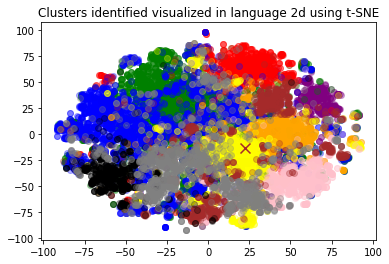

In [9]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embeddingMatrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

colors = ["purple", "green", "red", "blue", "orange", "yellow", "pink", "brown", "black", "grey", "cyan", "magenta", "lime", "indigo", "maroon", "olive", "navy", "teal", "gold", "tan", ]
for category, color in enumerate(colors[:n_clusters]):
    print(category, color)
    xs = np.array(x)[df_first_questions.Cluster == category]
    ys = np.array(y)[df_first_questions.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, It seems like the clusters are fairly homogonous. It would help if we optimized the cluster number based on the sillohuete score, but for consistency we will stick with Let's see a few samples from each cluster.

### Sort clusters by size and eyeball clusters

We sort the clusters by size and eyeball the clusters to see if they make sense. We should be looking to see whether each item has some similarity's to other items in the cluster

In [13]:
# sort clusters by their size, and create a new dataframe with the size and cluster number in sorted order. Maintain other columns
size_and_cluster_number = pd.DataFrame(df_first_questions.groupby("Cluster").size().sort_values(ascending=False))

# print out 10 messages from n cluster
for cluster_number, size in size_and_cluster_number.iteritems():
    print(f"{cluster_number} has {size} messages")
    print(df_first_questions[df_first_questions.Cluster == cluster_number].sample(4).message.values)
    print("\n")

3 has 3701 messages
['how do i run plan and execute'
 'how do I make a tool take multiple arguments of different types?'
 'How to check the response api header'
 'please give a code example how to use it']



1 has 3259 messages
['git repo' 'are google slides supported?' 'what time is it now?' '.']



9 has 1783 messages
['I want to compare cosine similarity with Faiss' 'how to use open ai'
 'Web検索をする機能をOpenAIのAPIにプラスする方法を教えて下さい。'
 'How can i utilize ChatOpenAi with the VectorDBQAWithSourcesChain\n\nchain = VectorDBQAWithSourcesChain.from_llm(llm=OpenAI(temperature=0, openai_api_key=openai_api), vectorstore=store)\n\n']



5 has 1432 messages
['how to install RedisChatMessageHistory'
 'I want to use the converstation token buffer memory, but i want to save all text that will be flushed to a string.'
 'Write a bash code to install chatGPT4 chatbot like. Write a bash code to install a model to chatbot that works offline locally. Write a Python code to make a chatbot usefull offline from 

<ipython-input-13-dc2c49aea450>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cluster_number, size in size_and_cluster_number.iteritems():


### Sample questions
Now, we can sample around 8000k tokens worth of questions. To do this, we shuffle the questions in each cluster, then cut the first 8000k token chunk from each cluster. This gives us a good representation of the questions in each cluster.

In [ ]:

from langchain.text_splitter import CharacterTextSplitter

def create_doc(messages, max_tokens=8000):
    #sample around 400 messages from the cluster
    input_doc = '\n\n'.join(messages)

    text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens,chunk_overlap=0,separator="\n\n")
    # Sanity check
    split_texts = text_splitter.split_text(input_doc)
    
    # text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=16000,chunk_overlap=0,separator="\n\n")
    return split_texts[0]


# for clusters, create docs and save in list
docs = []
for cluster_number, size in size_and_cluster_number.iteritems():
    print(f"{cluster_number} has {size} messages")
    messages = df_first_questions[df_first_questions.Cluster == cluster_number].message.values
    doc = create_doc(messages)
    print(doc)
    print("\n\n")
    docs.append(doc)


## Summarize with GPT-4

Alright, now its time to take these sample questions and turn them into something interperetable. We're going to use GPT-4 to find the overall themes with each cluster, along with the most common subthemes and topics in each cluster.

In [49]:
from langchain import PromptTemplate


map_template_string = """The following is a list of questions, commands, and keyords that have been entered into a Q+A system
{questions}

Based on this list of questions, please do 3 things: 
(1) Identify the main theme
(2) Give a list of main sub-themes
(3) Give a representitive example question in each sub-theme
(4) estimate the proportion of questions that fall into each theme

Helpful Answer:"""


MAP_PROMPT = PromptTemplate(input_variables=["questions"], template=map_template_string)


In [50]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=16000,chunk_overlap=0,separator="\n\n")

def run_map(input_doc):


    # llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k", temperature=0)

    llm = ChatOpenAI(model_name="gpt-4", temperature=0)
    map_llm_chain = LLMChain(llm=llm, prompt=MAP_PROMPT)

    
    return map_llm_chain.run(questions=input_doc)

Before we run this for each cluster, lets manually evalutate the first cluster to see if it makes sense.

In [51]:
test_result = run_map(docs[0])

print(test_result)

(1) Main Theme: Usage of a Q+A system for document processing and information retrieval.

(2) Main Sub-Themes:
   - Document Loaders: Questions about how to load different types of documents (PDF, txt, csv, etc.) into the system.
   - Text Splitters: Questions about how to split long texts into smaller chunks for processing.
   - Deployment: Questions about how to deploy the application or model.
   - Tools: Questions about how to create and use custom tools within the system.
   - Retrieval and Search: Questions about how to retrieve and search documents, and how to use different retrievers.
   - Error Handling: Questions about how to handle errors and issues encountered while using the system.
   - Memory Management: Questions about how to manage memory in the system, including how to add, delete, and update memory.
   - API Usage: Questions about how to use different APIs, including Google Search API, SerpAPI, etc.
   - Token Count: Questions about how to count tokens in a string or

Alright, now lets run it for each cluster and print the results.

In [52]:
initial_results = []

for input_doc in docs:
    result=run_map(input_doc)
    initial_results.append(result)

In [62]:
#print results
for i, result in enumerate(initial_results):

    #print size of cluster
    print(f"Cluster {i} has {size_and_cluster_number.iloc[i].values[0]} messages: \n")

    #print the summary
    print(result)

    #print separator
    print("\n===============================================================\n\n")
    




Cluster 0 has 3701 messages: 

(1) Main Theme: Usage and implementation of various features in a Q+A system.

(2) Main Sub-Themes:
   - Document Loaders: Questions about how to load different types of documents (PDF, txt, csv, etc.) into the system.
   - Text Splitters: Queries about splitting long texts into smaller chunks.
   - Deployment: Questions about how to deploy applications or models.
   - Tools: Queries about creating and using custom tools.
   - Retrieval and Search: Questions about retrieving documents, performing semantic search, and using specific retrievers.
   - Errors and Troubleshooting: Queries about resolving specific errors encountered while using the system.
   - Memory and Storage: Questions about memory usage, storage, and related issues.
   - API Usage: Queries about using different APIs (like SerpAPI, Pinecone, etc.) within the system.

(3) Representative Example Questions:
   - Document Loaders: "How do I load a bunch of text files from a directory into a we